In [13]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt

from lpspline import bs, l, pwl
from lpspline.constraints import Anchor, Monotonic, Concave, Convex
from lpspline.optimizer import LpRegressor
from lpspline.penalties import Ridge
from lpspline.viz import plot_diagnostic


# Create a sample dataset
np.random.seed(50)
N = 1000
x = np.linspace(-5, 5, N)
y = np.sin(x) + np.random.normal(0, 0.2, N) + 0.9*x

df = pl.DataFrame({"x": x, "y": y})


✨ Model Summary ✨
Problem Status: ✅ optimal
------------------------------------------------------------------------------------------------------------------------
Spline Type          | Term         | Tag             | Constraints          | Penalties            | Params  
------------------------------------------------------------------------------------------------------------------------
🟢 BSpline           | x            | bs              | None                 | None                 | 21      
------------------------------------------------------------------------------------------------------------------------
📊 Total Parameters                                                                                 | 21



(<Figure size 500x400 with 1 Axes>, array([<Axes: xlabel='x'>], dtype=object))

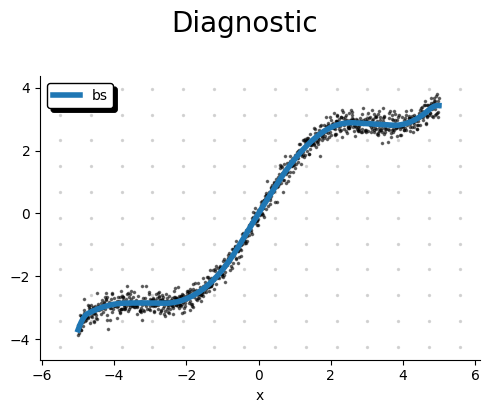

In [14]:
anchor_points = [(0,1), (2, 0)]

model = (
    +bs("x", knots=np.linspace(-10, 10, 20), degree=2, tag='bs')
)

model.fit(X=df, y=df['y'])



plot_diagnostic(model=model, X=df, y=df["y"])